## BSM Option Valuation

## Analyzing NASDAQ DATA

In [217]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.api as sm

In [219]:
mpl.rcParams['font.family'] = 'serif'

In [221]:
# Helper function for printing statistics
def print_statistics(data):
    ''' Prints selected statistics.
    Parameters
    ==========
    data: pandas DataFrame
        Data for which to calculate statistics
    '''
    sta = scs.describe(data)
    print('%14s %15s' % ('statistic', 'value'))
    print(30 * "-")
    print('%14s %15.5f' % ('size', sta[0]))
    print('%14s %15.5f' % ('min', sta[1][0]))
    print('%14s %15.5f' % ('max', sta[1][1]))
    print('%14s %15.5f' % ('mean', sta[2]))
    print('%14s %15.5f' % ('std', np.sqrt(sta[3])))
    print('%14s %15.5f' % ('skew', sta[4]))
    print('%14s %15.5f' % ('kurtosis', sta[5]))

In [223]:
# Helper function for the normal distribution PDF
def dN(x, mu, sigma):
    ''' Probability density function of a normal random variable x.
    Parameters
    ==========
    mu: float
        expected value
    sigma: float
        standard deviation
    Returns
    =======
    pdf: float
        value of probability density function
    '''
    z = (x - mu) / sigma
    pdf = np.exp(-0.5 * z ** 2) / np.sqrt(2 * np.pi * sigma ** 2)
    return pdf

In [225]:
# Download NASDAQ data using yfinance of Microsoft Stock
nsdq = yf.download('MSFT', start='1990-01-01', end='2024-05-24')

# Use the 'Close' column for analysis
nsdq = nsdq[['Close']]
nsdq.rename(columns={'Close': 'index'}, inplace=True)

nsdq.info()
print(nsdq.head())
print(nsdq.tail())

[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8665 entries, 1990-01-02 to 2024-05-23
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (index, MSFT)  8665 non-null   float64
dtypes: float64(1)
memory usage: 135.4 KB
Price          index
Ticker          MSFT
Date                
1990-01-02  0.378500
1990-01-03  0.380633
1990-01-04  0.391828
1990-01-05  0.382232
1990-01-08  0.388096
Price            index
Ticker            MSFT
Date                  
2024-05-17  417.778351
2024-05-20  422.878632
2024-05-21  426.557281
2024-05-22  428.028687
2024-05-23  424.529083


     statistic           value
------------------------------
          size      8664.00000
           min        -0.16958
           max         0.17869
          mean         0.00081
           std         0.01989
          skew        -0.02293
      kurtosis         6.16968


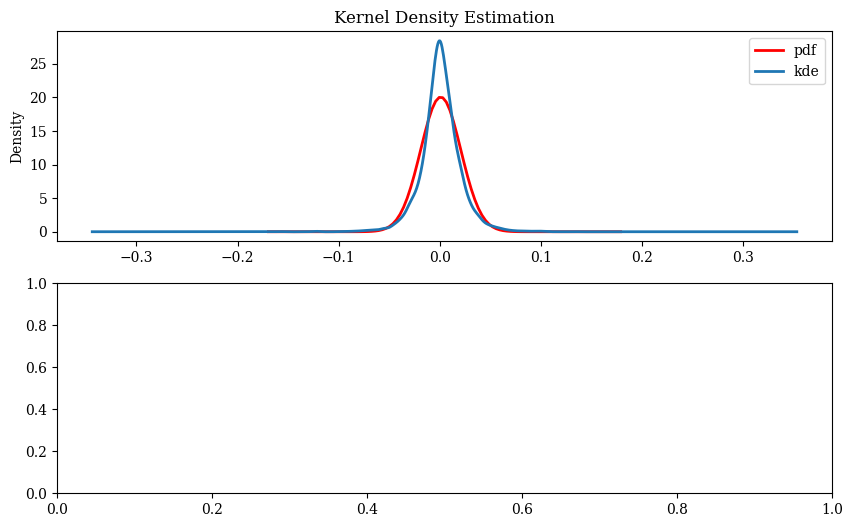

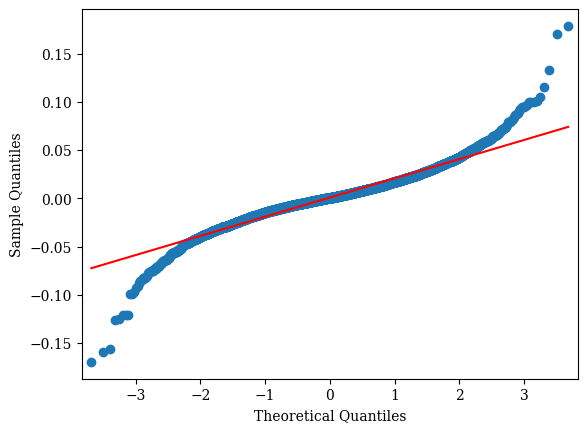

In [227]:
# Calculate log returns
nsdq['log_return'] = np.log(nsdq['index'] / nsdq['index'].shift(1))

# Print summary statistics
print_statistics(nsdq['log_return'].dropna())

# Kernel Density Estimation and Q-Q plot
plt.figure(figsize=(10, 6))

# Kernel Density Estimation
plt.subplot(211)
x = np.linspace(min(nsdq['log_return'].dropna()), max(nsdq['log_return'].dropna()), 100)
plt.plot(x, dN(x, nsdq['log_return'].mean(), nsdq['log_return'].std()), 'r', lw=2.0, label='pdf')
nsdq['log_return'].dropna().plot(kind='kde', title='Kernel Density Estimation', label='kde', lw=2.0)
plt.legend()

# Q-Q plot
plt.subplot(212)
sm.qqplot(nsdq['log_return'].dropna(), line='s')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.show()

In [173]:
#IMPLIED VOL

In [229]:
def read_nsdq_data():
    '''Reads historical NASDAQ data from Yahoo! Finance, calculates log returns, realized variance, and volatility.'''
    nsdq = yf.download('MSFT', start='2004-09-30', end='2014-09-30')
    nsdq.rename(columns={'Close': 'index'}, inplace=True)
    nsdq['returns'] = np.log(nsdq['index'] / nsdq['index'].shift(1))
    nsdq['rea_var'] = 252 * np.cumsum(nsdq['returns'] ** 2) / np.arange(len(nsdq))
    nsdq['rea_vol'] = np.sqrt(nsdq['rea_var'])
    nsdq = nsdq.dropna()
    return nsdq

In [231]:
def count_jumps(data, value):
    '''Counts the number of return jumps as defined in size by value.'''
    jumps = np.sum(np.abs(data['returns']) > value)
    return jumps

def realized_volatility(data):
    '''Plots the realized volatility.'''
    plt.figure(figsize=(9, 5))
    data['rea_vol'].plot()
    plt.ylabel('Realized Volatility')
    plt.grid(True)
    plt.show()

In [233]:
def rolling_statistics(data):
    '''Calculates and plots rolling statistics (mean, std, correlation).'''
    plt.figure(figsize=(11, 8))
    plt.subplot(311)
    mr = data['returns'].rolling(window=252).mean() * 252
    mr.plot()
    plt.grid(True)
    plt.ylabel('Returns (252d)')
    plt.axhline(mr.mean(), color='r', ls='dashed', lw=1.5)
    
    plt.subplot(312)
    vo = data['returns'].rolling(window=252).std() * np.sqrt(252)
    vo.plot()
    plt.grid(True)
    plt.ylabel('Volatility (252d)')
    plt.axhline(vo.mean(), color='r', ls='dashed', lw=1.5)
    vx = plt.axis()
    
    plt.subplot(313)
    co = mr.rolling(window=252).corr(vo)
    co.plot()
    plt.grid(True)
    plt.ylabel('Correlation (252d)')
    cx = plt.axis()
    plt.axis([vx[0], vx[1], cx[2], cx[3]])
    plt.axhline(co.mean(), color='r', ls='dashed', lw=1.5)
    plt.show()

[*********************100%***********************]  1 of 1 completed


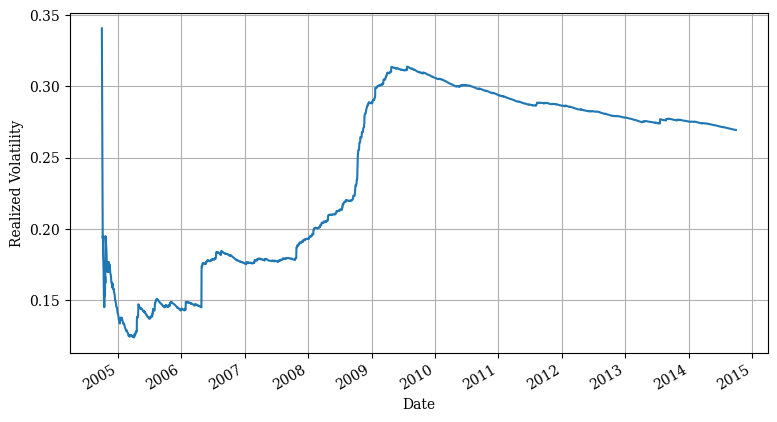

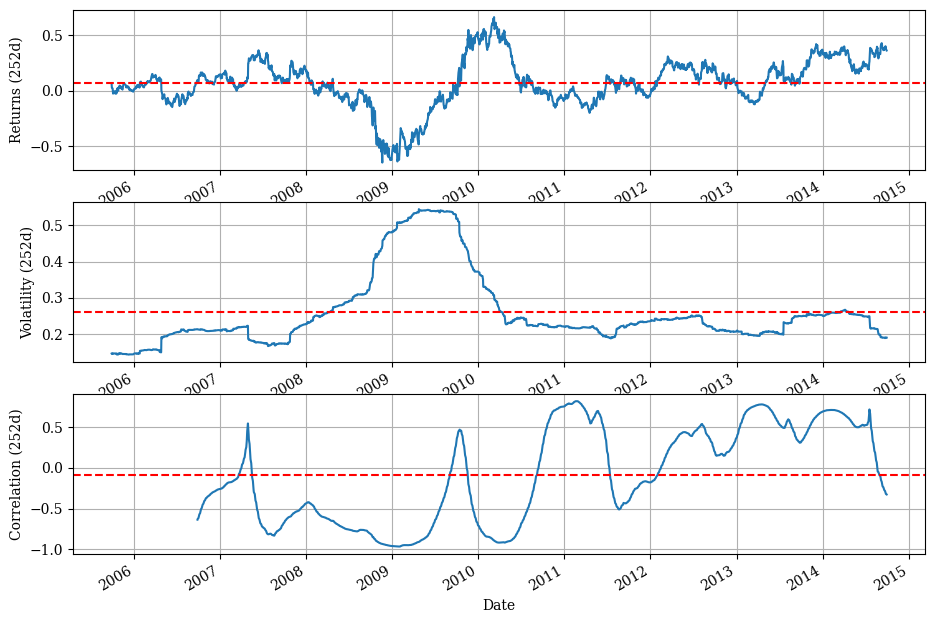

Number of jumps greater than 0.05: 43


In [235]:
# Example usage
nsdq_data = read_nsdq_data()
realized_volatility(nsdq_data)
rolling_statistics(nsdq_data)
print("Number of jumps greater than 0.05:", count_jumps(nsdq_data, 0.05))

## Black-Scholes-Merton (BSM) Option Valuation Script

In [238]:
import math
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [240]:
# Helper Functions
def dN(x):
    '''Probability density function of standard normal random variable x.'''
    return math.exp(-0.5 * x ** 2) / math.sqrt(2 * math.pi)

def N(d):
    '''Cumulative density function of standard normal random variable x.'''
    return quad(lambda x: dN(x), -20, d, limit=50)[0]

def d1f(St, K, t, T, r, sigma):
    '''Black-Scholes-Merton d1 function.'''
    d1 = (math.log(St / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * math.sqrt(T - t))
    return d1

In [242]:
# Valuation Functions
def BSM_call_value(St, K, t, T, r, sigma):
    '''Calculates Black-Scholes-Merton European call option value.'''
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    call_value = St * N(d1) - math.exp(-r * (T - t)) * K * N(d2)
    return call_value

def BSM_put_value(St, K, t, T, r, sigma):
    '''Calculates Black-Scholes-Merton European put option value.'''
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    put_value = math.exp(-r * (T - t)) * K * N(-d2) - St * N(-d1)
    return put_value

In [244]:
# Parameters
symbol = 'NDX'  # Nasdaq-100 Index
data = yf.Ticker(symbol)
hist = data.history(period="1y")

# Extract relevant data
St = hist['Close'].iloc[-1]  # last closing price
K = St  # At-the-money option
t = 0  # valuation date
T = 1.0  # maturity in years
r = 0.05  # risk-free rate
sigma = hist['Close'].pct_change().std() * np.sqrt(252)  # annualized volatility

In [245]:
# Calculate option values
call_value = BSM_call_value(St, K, t, T, r, sigma)
put_value = BSM_put_value(St, K, t, T, r, sigma)

print(f"BSM European Call Option Value: {call_value:.2f}")
print(f"BSM European Put Option Value: {put_value:.2f}")

BSM European Call Option Value: 2528.91
BSM European Put Option Value: 1548.50


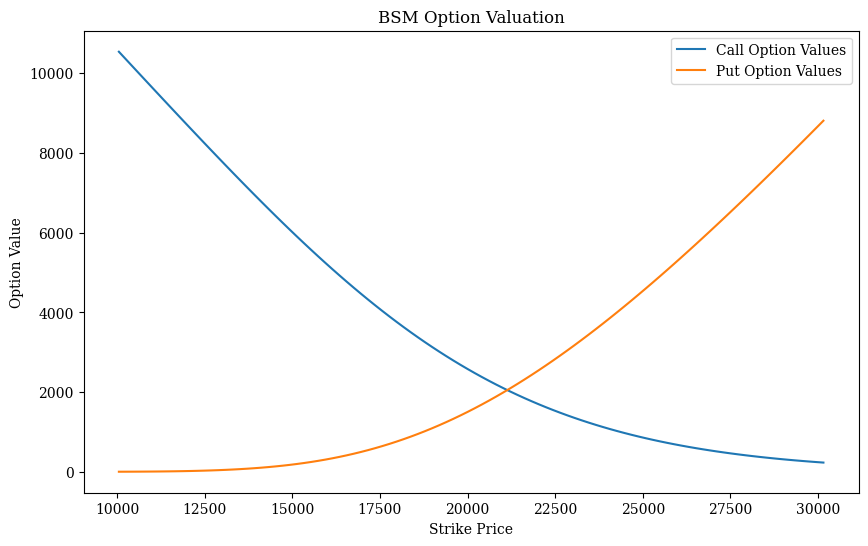

In [248]:
# Plotting the values
Ks = np.linspace(St * 0.5, St * 1.5, 100)
call_values = [BSM_call_value(St, K, t, T, r, sigma) for K in Ks]
put_values = [BSM_put_value(St, K, t, T, r, sigma) for K in Ks]

plt.figure(figsize=(10, 6))
plt.plot(Ks, call_values, label='Call Option Values')
plt.plot(Ks, put_values, label='Put Option Values')
plt.xlabel('Strike Price')
plt.ylabel('Option Value')
plt.title('BSM Option Valuation')
plt.legend()
plt.show()

#### Explanation
Helper Functions: Functions dN and N compute the standard normal density and cumulative density, respectively. d1f computes the d1 term used in the BSM formula.

Valuation Functions: Functions BSM_call_value and BSM_put_value calculate the European call and put option values using the BSM model.

Parameters: The script fetches historical data for the Nasdaq-100 Index from Yahoo Finance to calculate the last closing price (St) and the annualized volatility (sigma).

Option Values Calculation: The script computes and prints the BSM values for a European call and put option.

Plotting: The script generates a plot showing how the option values change with varying strike prices.

## Black-Scholes-Merton (BSM) Call Option Greek

In [252]:
import math
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta

In [254]:
# Black-Scholes-Merton Functions for Greeks

def d1f(St, K, t, T, r, sigma):
    return (math.log(St / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * math.sqrt(T - t))

def N(x):
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

def dN(x):
    return math.exp(-0.5 * x ** 2) / math.sqrt(2 * math.pi)

In [256]:
def BSM_delta(St, K, t, T, r, sigma):
    ''' Black-Scholes-Merton DELTA of European call option. '''
    d1 = d1f(St, K, t, T, r, sigma)
    return N(d1)

def BSM_gamma(St, K, t, T, r, sigma):
    ''' Black-Scholes-Merton GAMMA of European call option. '''
    d1 = d1f(St, K, t, T, r, sigma)
    return dN(d1) / (St * sigma * math.sqrt(T - t))

def BSM_theta(St, K, t, T, r, sigma):
    ''' Black-Scholes-Merton THETA of European call option. '''
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    first_term = - (St * dN(d1) * sigma) / (2 * math.sqrt(T - t))
    second_term = r * K * math.exp(-r * (T - t)) * N(d2)
    return first_term - second_term

def BSM_vega(St, K, t, T, r, sigma):
    ''' Black-Scholes-Merton VEGA of European call option. '''
    d1 = d1f(St, K, t, T, r, sigma)
    return St * dN(d1) * math.sqrt(T - t)

def BSM_rho(St, K, t, T, r, sigma):
    ''' Black-Scholes-Merton RHO of European call option. '''
    d1 = d1f(St, K, t, T, r, sigma)
    d2 = d1 - sigma * math.sqrt(T - t)
    return K * (T - t) * math.exp(-r * (T - t)) * N(d2)

In [258]:
# Yahoo Finance Data Extraction

def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    return data['Close']

# Parameters
ticker = 'AAPL'
start_date = datetime.today() - timedelta(days=365)
end_date = datetime.today()

In [260]:
# Get stock price data
stock_data = get_stock_data(ticker, start_date, end_date)
St = stock_data[-1]  # Last available closing price
K = 150  # Strike price
t = 0  # Valuation date (now)
T = 1  # Maturity in 1 year
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility

C:\Users\shukl\AppData\Local\Temp\ipykernel_17920\3884473487.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  St = stock_data[-1]  # Last available closing price


In [262]:
# Greeks Calculation
delta = BSM_delta(St, K, t, T, r, sigma)
gamma = BSM_gamma(St, K, t, T, r, sigma)
theta = BSM_theta(St, K, t, T, r, sigma)
vega = BSM_vega(St, K, t, T, r, sigma)
rho = BSM_rho(St, K, t, T, r, sigma)

In [264]:
print(f"Delta: {delta}")
print(f"Gamma: {gamma}")
print(f"Theta: {theta}")
print(f"Vega: {vega}")
print(f"Rho: {rho}")

Delta: 0.9725964849815318
Gamma: 0.0015365892340069981
Theta: -8.125651981935363
Vega: 12.959171039638973
Rho: 136.5946975594293


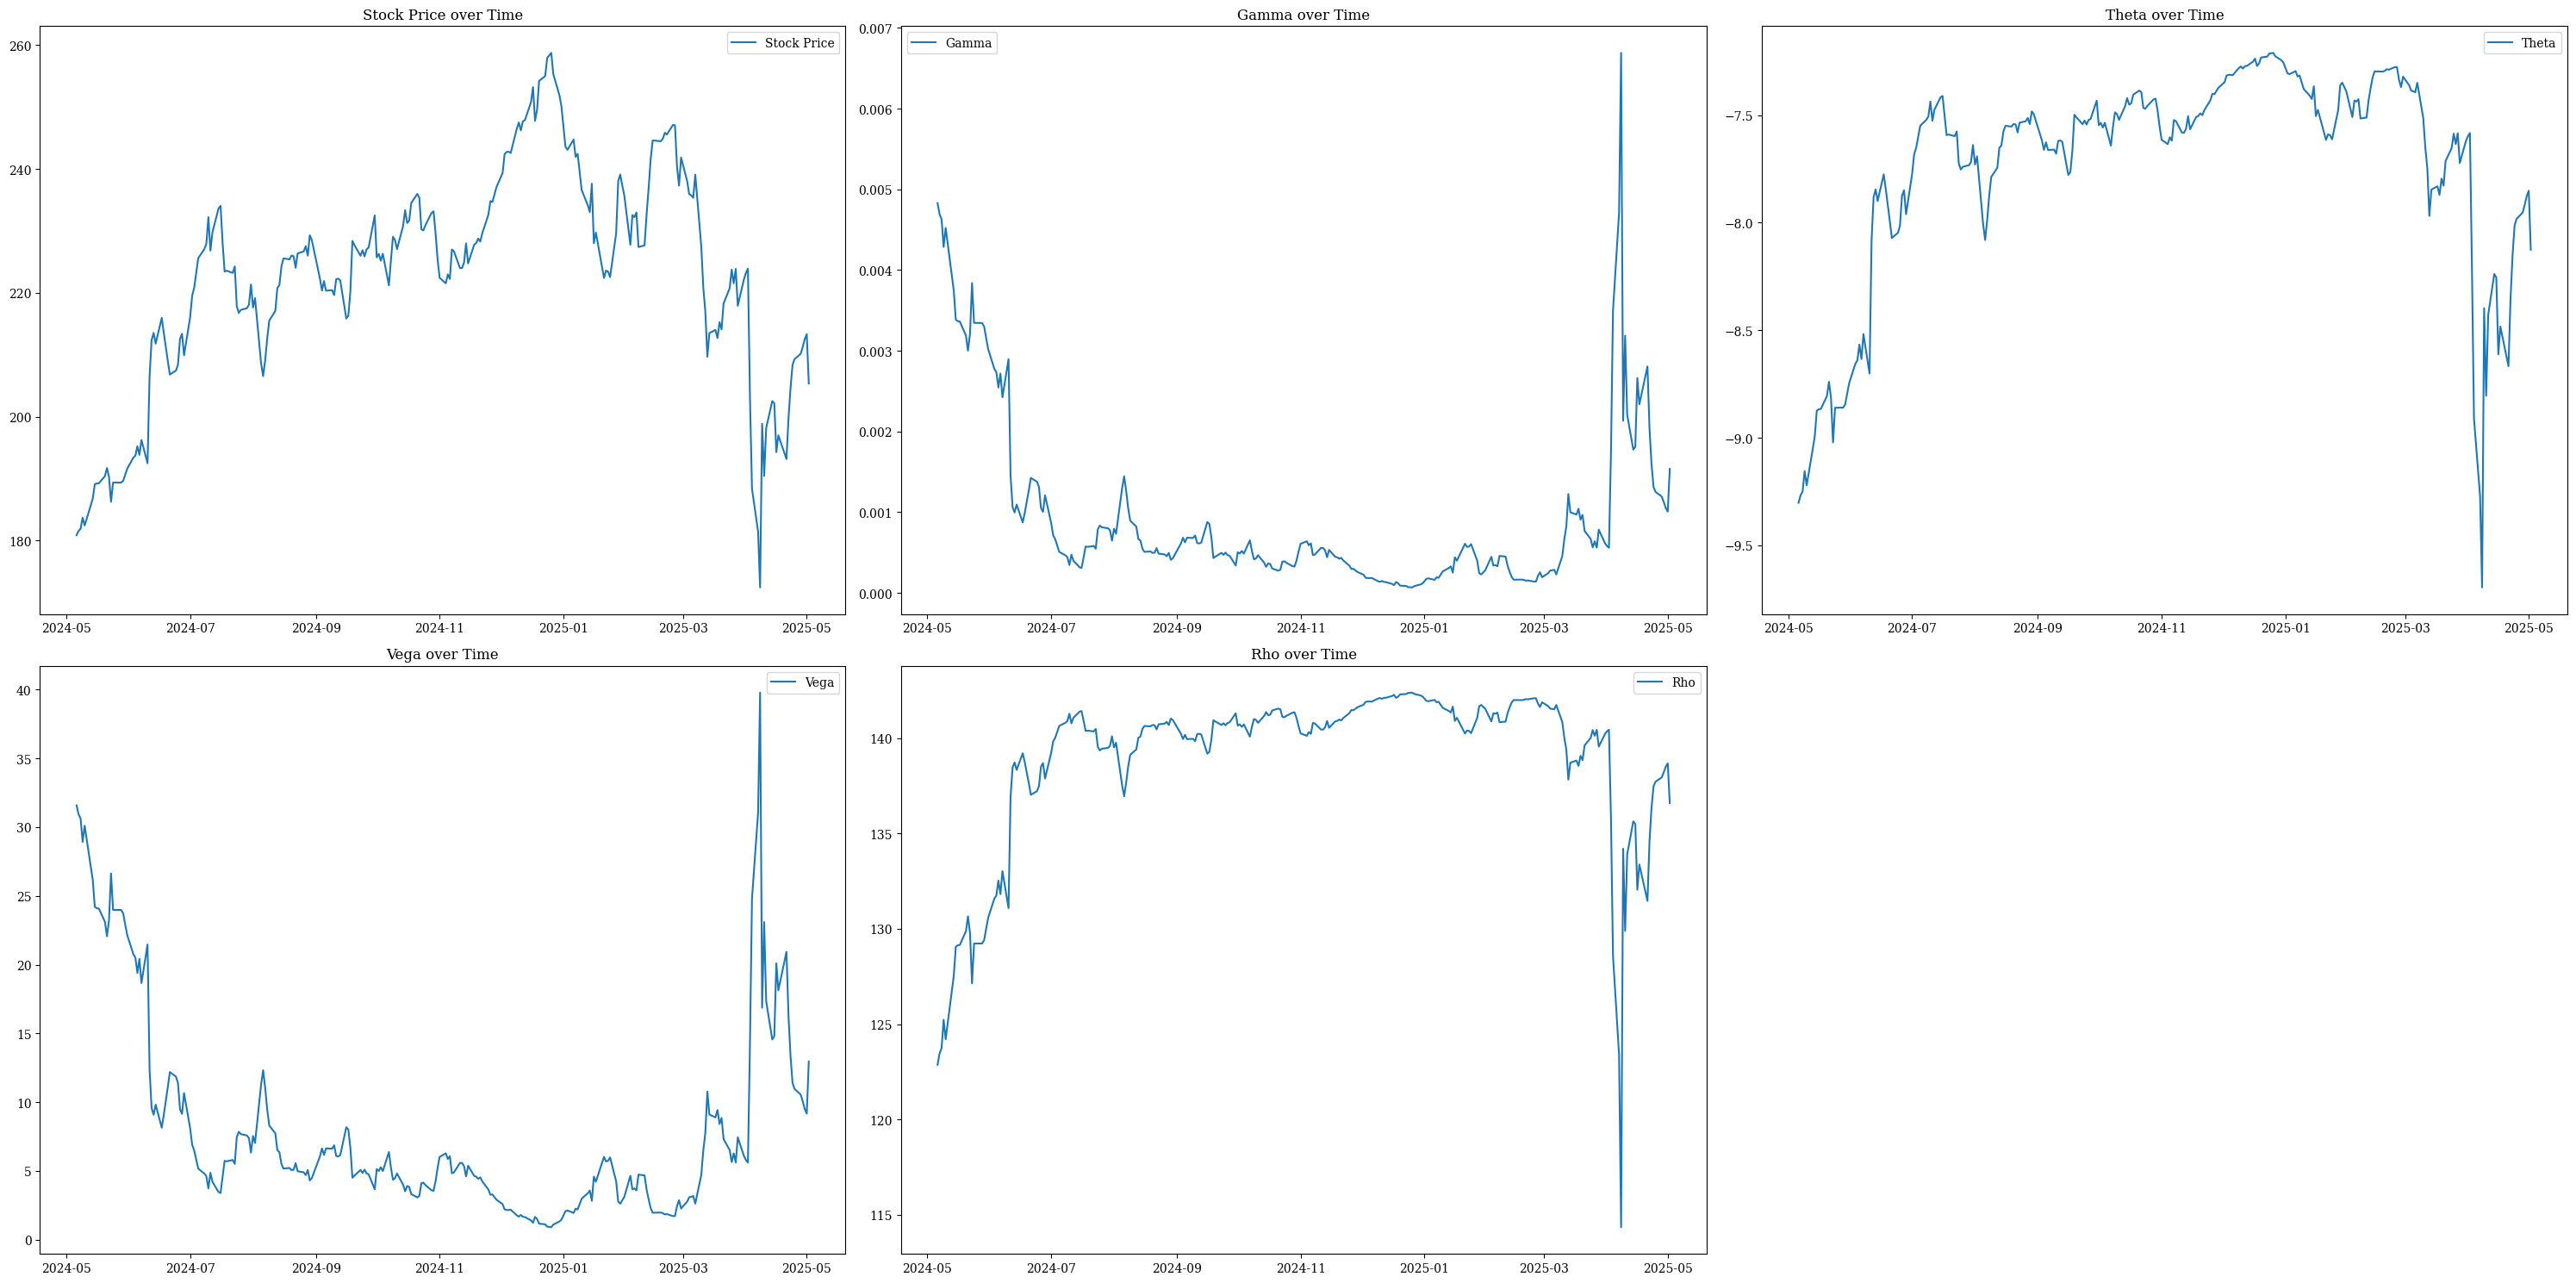

In [266]:
# Visualization
plt.figure(figsize=(30,15))

# Delta plot
plt.subplot(231)
plt.plot(stock_data.index, stock_data, label='Stock Price')
plt.title('Stock Price over Time')
plt.legend()

# Gamma plot
plt.subplot(232)
plt.plot(stock_data.index, [BSM_gamma(price, K, t, T, r, sigma) for price in stock_data], label='Gamma')
plt.title('Gamma over Time')
plt.legend()

# Theta plot
plt.subplot(233)
plt.plot(stock_data.index, [BSM_theta(price, K, t, T, r, sigma) for price in stock_data], label='Theta')
plt.title('Theta over Time')
plt.legend()

# Vega plot
plt.subplot(234)
plt.plot(stock_data.index, [BSM_vega(price, K, t, T, r, sigma) for price in stock_data], label='Vega')
plt.title('Vega over Time')
plt.legend()

# Rho plot
plt.subplot(235)
plt.plot(stock_data.index, [BSM_rho(price, K, t, T, r, sigma) for price in stock_data], label='Rho')
plt.title('Rho over Time')
plt.legend()

plt.tight_layout()
plt.show()